<a href="https://colab.research.google.com/github/ganireddikumar/Assignment1/blob/main/extras/exercises/08_pytorch_paper_replicating_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. PyTorch Paper Replicating Exercises

Welcome to the 08. PyTorch Paper Replicating exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/tjpW_BY8y3g) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/).

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")


[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cu113
torch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1540/1540), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 4393 (delta 1459), reused 1408 (delta 1401), pack-reused 2853 (from 1)
Receiving objects: 100% (4393/4393), 650.73 MiB | 15.46 MiB/s, done.
Resolving deltas: 100% (2661/2661), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

Want to download the data we've been using in PyTorch Paper Replicating: https://www.learnpytorch.io/08_pytorch_paper_replicating/#1-get-data

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [6]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7bbce62a2850>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

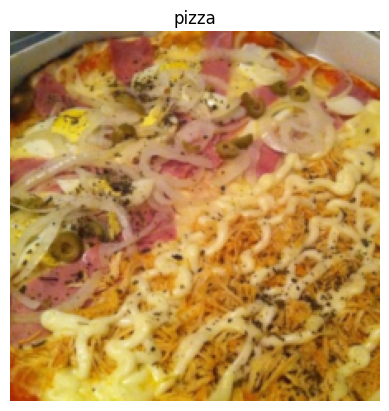

In [9]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## 1. Replicate the ViT architecture we created with in-built [PyTorch transformer layers](https://pytorch.org/docs/stable/nn.html#transformer-layers).

* You'll want to look into replacing our `TransformerEncoderBlock()` class with [`torch.nn.TransformerEncoderLayer()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) (these contain the same layers as our custom blocks).
* You can stack `torch.nn.TransformerEncoderLayer()`'s on top of each other with [`torch.nn.TransformerEncoder()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder).

In [10]:
# TODO: your code
rand_image_tensor = torch.rand(32,3,224,224)
rand_image_tensor.shape

torch.Size([32, 3, 224, 224])

In [11]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768):
    super().__init__()
    self.patch_size = patch_size
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)

  def forward(self,x):
    image_resolution = x.shape[-1]
    assert image_resolution % self.patch_size ==0,f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    return x_flattened.permute(0,2,1)

In [13]:


transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                      nhead=12,
                                                      dim_feedforward=3072,  # Changed from dim_feed_forward to dim_feedforward
                                                      dropout=0.1,
                                                      activation="gelu",
                                                      batch_first=True,
                                                      norm_first=True)
transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [41]:
from torchinfo import summary

# Create an instance of the PatchEmbedding class
patch_embedding = PatchEmbedding()

# Create a random input tensor
rand_image_tensor = torch.rand(32, 3, 224, 224)

# Pass the random input tensor through the PatchEmbedding layer to get the output
patch_embedding_output = patch_embedding(rand_image_tensor)

# Now you can use patch_embedding_output.shape in the summary function
summary(model=transformer_encoder_layer,
        input_size=patch_embedding_output.shape)

Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoderLayer                  [32, 196, 768]            --
├─LayerNorm: 1-1                         [32, 196, 768]            1,536
├─MultiheadAttention: 1-2                [32, 196, 768]            2,362,368
├─Dropout: 1-3                           [32, 196, 768]            --
├─LayerNorm: 1-4                         [32, 196, 768]            1,536
├─Linear: 1-5                            [32, 196, 3072]           2,362,368
├─Dropout: 1-6                           [32, 196, 3072]           --
├─Linear: 1-7                            [32, 196, 768]            2,360,064
├─Dropout: 1-8                           [32, 196, 768]            --
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 151.22
Input size (MB): 19.27
Forward/backward pass size (MB): 269.75
Params size (MB): 18.90
Estimated Total Size (MB): 307.92

In [15]:
transformer_encoder = nn.TransformerEncoder(encoder_layer=transformer_encoder_layer,
                                            num_layers=12)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [16]:
class ViT(nn.Module):
  def __init__(self,
               img_size=224,
               num_channels=3,
               patch_size=16,
               embedding_dim=768,
               dropout=0.1,
               mlp_size=3072,
               num_transformer_layers=12,
               num_heads=12,
               num_classes=1000):
    super().__init__()
    assert img_size % patch_size ==0,"Image size must be divisble by patch size."

    self.patch_embedding = PatchEmbedding(in_channels=num_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)
    self.class_token = nn.Parameter(torch.randn(1,1,embedding_dim),
                                    requires_grad=True)
    num_patches = (img_size *img_size)// patch_size**2
    self.positional_embedding = nn.Parameter(torch.randn(1,num_patches+1,embedding_dim))

    self.embedding_dropout = nn.Dropout(p=dropout)

    self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                              nhead=num_heads,
                                                                                              dim_feedforward=mlp_size,
                                                                                              activation="gelu",
                                                                                              batch_first=True,
                                                                                              norm_first=True), # Create a single Transformer Encoder Layer
                                                     num_layers=num_transformer_layers)
    self.mlp_head = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self,x):
    batch_size=x.shape[0]
    x = self.patch_embedding(x)
    class_token =self.class_token.expand(batch_size,-1,-1)

    x=torch.cat((class_token,x),dim=1)

    x=self.positional_embedding +x

    x = self.embedding_dropout(x)

    x = self.transformer_encoder(x)

    x = self.mlp_head(x[:,0])

    return x


In [17]:
demo_img =torch.randn(1,3,224,224).to(device)
print(demo_img.shape)

torch.Size([1, 3, 224, 224])


In [18]:
vit = ViT(num_classes=len(class_names)).to(device)
vit(demo_img)

tensor([[ 0.5777, -0.5874, -0.1128]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [19]:
summary(model=ViT(num_classes=3),
        input_size=demo_img.shape)

Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [1, 3]                    152,064
├─PatchEmbedding: 1-1                         [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─TransformerEncoder: 1-3                     [1, 197, 768]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-2      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-3      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-4      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-5      [1, 197, 76

In [20]:
len(class_names)

3

In [21]:
embedding_dim =768
class_token=nn.Parameter(torch.randn(1,1,embedding_dim),
                         requires_grad=True)
class_token.requires_grad

True

In [22]:
batch_size=32
print(class_token.shape)
class_token.expand(batch_size,-1,-1).shape

torch.Size([1, 1, 768])


torch.Size([32, 1, 768])

In [23]:
patch_size=16
img_size=224
num_patches = (img_size*img_size)//patch_size**2
pos_embedding= nn.Parameter(torch.randn(1,num_patches+1,embedding_dim))
pos_embedding.shape

torch.Size([1, 197, 768])

## 2. Turn the custom ViT architecture we created into a Python script, for example, `vit.py`.

* You should be able to import an entire ViT model using something like`from vit import ViT`.
* We covered the art of turning code cells into Python scrips in [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/).


In [24]:
# TODO: your code
%%writefile vit.py
import torch
from torch import nn

# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        self.patch_size = patch_size

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

class ViT(nn.Module):
  def __init__(self,
               img_size=224, # from Table 3
               num_channels=3,
               patch_size=16,
               embedding_dim=768, # from Table 1
               dropout=0.1,
               mlp_size=3072, # from Table 1
               num_transformer_layers=12, # from Table 1
               num_heads=12, # from Table 1 (number of multi-head self attention heads)
               num_classes=1000): # generic number of classes (this can be adjusted)
    super().__init__()

    # Assert image size is divisible by patch size
    assert img_size % patch_size == 0, "Image size must be divisble by patch size."

    # 1. Create patch embedding
    self.patch_embedding = PatchEmbedding(in_channels=num_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # 2. Create class token
    self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                    requires_grad=True)

    # 3. Create positional embedding
    num_patches = (img_size * img_size) // patch_size**2 # N = HW/P^2
    self.positional_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim))

    # 4. Create patch + position embedding dropout
    self.embedding_dropout = nn.Dropout(p=dropout)

    # # 5. Create Transformer Encoder layer (single)
    # self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
    #                                                             nhead=num_heads,
    #                                                             dim_feedforward=mlp_size,
    #                                                             activation="gelu",
    #                                                             batch_first=True,
    #                                                             norm_first=True)

    # 5. Create stack Transformer Encoder layers (stacked single layers)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                              nhead=num_heads,
                                                                                              dim_feedforward=mlp_size,
                                                                                              activation="gelu",
                                                                                              batch_first=True,
                                                                                              norm_first=True), # Create a single Transformer Encoder Layer
                                                     num_layers=num_transformer_layers) # Stack it N times

    # 7. Create MLP head
    self.mlp_head = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    # Get some dimensions from x
    batch_size = x.shape[0]

    # Create the patch embedding
    x = self.patch_embedding(x)
    # print(x.shape)

    # First, expand the class token across the batch size
    class_token = self.class_token.expand(batch_size, -1, -1) # "-1" means infer the dimension

    # Prepend the class token to the patch embedding
    x = torch.cat((class_token, x), dim=1)
    # print(x.shape)

    # Add the positional embedding to patch embedding with class token
    x = self.positional_embedding + x
    # print(x.shape)

    # Dropout on patch + positional embedding
    x = self.embedding_dropout(x)

    # Pass embedding through Transformer Encoder stack
    x = self.transformer_encoder(x)

    # Pass 0th index of x through MLP head
    x = self.mlp_head(x[:, 0])

    return x

Writing vit.py


## 3. Train a pretrained ViT feature extractor model (like the one we made in [08. PyTorch Paper Replicating section 10](https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-bring-in-pretrained-vit-from-torchvisionmodels-on-same-dataset)) on 20% of the pizza, steak and sushi data like the dataset we used in [07. PyTorch Experiment Tracking section 7.3](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#73-download-different-datasets)
* See how it performs compared to the EffNetB2 model we compared it to in [08. PyTorch Paper Replicating section 10.6](https://www.learnpytorch.io/08_pytorch_paper_replicating/#106-save-feature-extractor-vit-model-and-check-file-size).

In [25]:
# TODO: your code
set_seeds()

In [26]:
import torchvision

vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=vit_weights)

for param in pretrained_vit.parameters():
  param.requires_grad=False

embedding_dim=768
set_seeds()
pretrained_vit.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape=embedding_dim),
    nn.Linear(in_features=embedding_dim,
              out_features=len(class_names))
)

summary(model=pretrained_vit,
        input_size=(1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 173MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [27]:
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")
train_dir_20_percent = data_20_percent_path /"train"

vit_transforms= vit_weights.transforms()
train_dataloader_20_percent , test_dataloader,class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                           test_dir=test_dir, # use 10% data for testing
                                                                                           transform=vit_transforms,
                                                                                           batch_size=32)


[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


In [28]:
len(train_dataloader), len(train_dataloader_20_percent), len(test_dataloader)

(8, 15, 3)

In [29]:
from going_modular.going_modular import engine
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr = 1e-3)
loss_fn = torch.nn.CrossEntropyLoss()
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader =train_dataloader_20_percent,
                                      test_dataloader = test_dataloader,
                                      optimizer = optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6443 | train_acc: 0.7521 | test_loss: 0.2314 | test_acc: 0.9072
Epoch: 2 | train_loss: 0.2036 | train_acc: 0.9167 | test_loss: 0.2301 | test_acc: 0.9186
Epoch: 3 | train_loss: 0.1399 | train_acc: 0.9583 | test_loss: 0.1990 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.1000 | train_acc: 0.9688 | test_loss: 0.1778 | test_acc: 0.9688
Epoch: 5 | train_loss: 0.0881 | train_acc: 0.9771 | test_loss: 0.1803 | test_acc: 0.9384
Epoch: 6 | train_loss: 0.0924 | train_acc: 0.9521 | test_loss: 0.1705 | test_acc: 0.9583
Epoch: 7 | train_loss: 0.0655 | train_acc: 0.9812 | test_loss: 0.1785 | test_acc: 0.9583
Epoch: 8 | train_loss: 0.0575 | train_acc: 0.9875 | test_loss: 0.2006 | test_acc: 0.9384
Epoch: 9 | train_loss: 0.0657 | train_acc: 0.9938 | test_loss: 0.2046 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0411 | train_acc: 0.9938 | test_loss: 0.1877 | test_acc: 0.9280


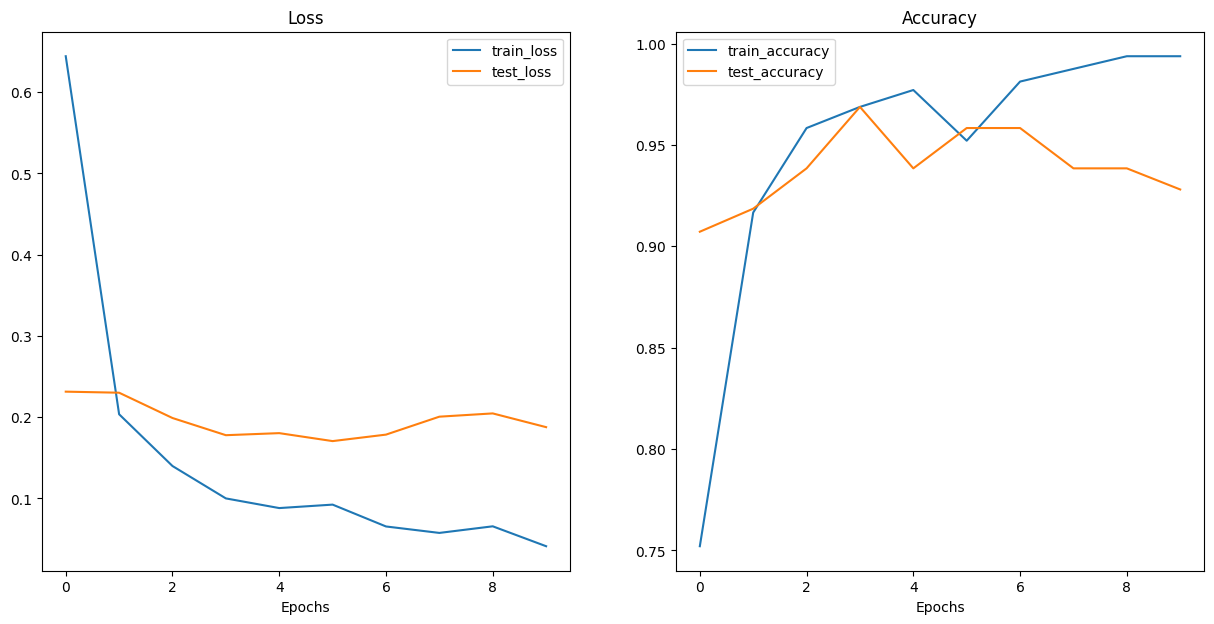

In [30]:
from helper_functions import plot_loss_curves
plot_loss_curves(pretrained_vit_results)

## 4. Try repeating the steps from excercise 3 but this time use the "`ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1`" pretrained weights from [`torchvision.models.vit_b_16()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16).
* Note: ViT pretrained with SWAG weights has a minimum input image size of (384, 384), though this is accessible in the weights `.transforms()` method.

In [31]:
# TODO: your code
import torchvision

vit_weights_swag = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1 # get SWAG weights
pretrained_vit_swag = torchvision.models.vit_b_16(weights=vit_weights_swag)

# Freeze all layers in pretrained ViT model
for param in pretrained_vit_swag.parameters():
  param.requires_grad = False

# Update the preatrained ViT head
embedding_dim = 768 # ViT_Base
set_seeds()
pretrained_vit_swag.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape=embedding_dim),
    nn.Linear(in_features=embedding_dim,
              out_features=len(class_names))
)

# Print a summary
summary(model=pretrained_vit_swag,
        input_size=(1, 3, 384, 384), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Downloading: "https://download.pytorch.org/models/vit_b_16_swag-9ac1b537.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16_swag-9ac1b537.pth
100%|██████████| 331M/331M [00:02<00:00, 168MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 384, 384]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 384, 384]     [1, 768, 24, 24]     (590,592)            False
├─Encoder (encoder)                                          [1, 577, 768]        [1, 577, 768]        443,136              False
│    └─Dropout (dropout)                                     [1, 577, 768]        [1, 577, 768]        --                   --
│    └─Sequential (layers)                                   [1, 577, 768]        [1, 577, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 577, 768]        [1, 577, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 577, 768]        [1, 5

In [32]:
vit_transforms_swag = vit_weights_swag.transforms() # get transforms from vit_weights_swag
vit_transforms_swag

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [33]:
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

# Setup train and test directories
train_dir_20_percent = data_20_percent_path / "train"
# test_dir_20_percent = data_20_percent_path / "test" # don't need 20% test data as the model in 07. PyTorch Experiment Tracking section 7.3 tests on the 10% dataset not the 20%

# Preprocess the data
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                          test_dir=test_dir, # use 10% data for testing
                                                                                          transform=vit_transforms_swag,
                                                                                          batch_size=32)


[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


In [34]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=pretrained_vit_swag.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_swag_results = engine.train(model=pretrained_vit_swag,
                                      train_dataloader=train_dataloader_20_percent,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4661 | train_acc: 0.9000 | test_loss: 0.0779 | test_acc: 0.9792
Epoch: 2 | train_loss: 0.0641 | train_acc: 0.9854 | test_loss: 0.0619 | test_acc: 0.9896
Epoch: 3 | train_loss: 0.0407 | train_acc: 0.9875 | test_loss: 0.0488 | test_acc: 0.9896
Epoch: 4 | train_loss: 0.0300 | train_acc: 0.9938 | test_loss: 0.0427 | test_acc: 0.9896
Epoch: 5 | train_loss: 0.0241 | train_acc: 0.9938 | test_loss: 0.0435 | test_acc: 0.9896
Epoch: 6 | train_loss: 0.0205 | train_acc: 0.9979 | test_loss: 0.0405 | test_acc: 0.9896
Epoch: 7 | train_loss: 0.0168 | train_acc: 0.9979 | test_loss: 0.0387 | test_acc: 0.9896
Epoch: 8 | train_loss: 0.0197 | train_acc: 0.9979 | test_loss: 0.0396 | test_acc: 0.9896
Epoch: 9 | train_loss: 0.0131 | train_acc: 1.0000 | test_loss: 0.0489 | test_acc: 0.9896
Epoch: 10 | train_loss: 0.0123 | train_acc: 0.9979 | test_loss: 0.0403 | test_acc: 0.9896


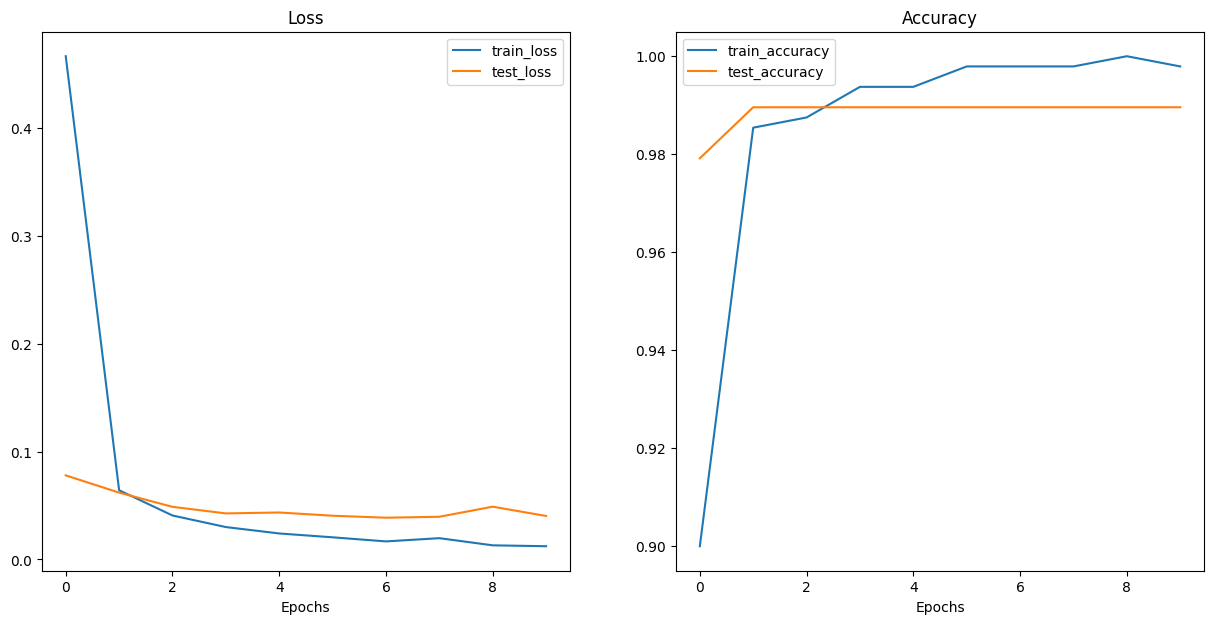

In [35]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_swag_results)

In [37]:
from tqdm import tqdm
from pathlib import Path
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

test_labels = [path.parent.stem for path in test_data_paths]

def pred_and_store(test_paths,model,transform,class_names,device):
  test_pred_list =[]
  for path in tqdm(test_paths):
    pred_dict ={}
    pred_dict["image_path"]=path
    class_name= path.parent.stem
    pred_dict["class_name"]=class_name

    from PIL import Image
    img = Image.open(path)
    transformed_image = transform(img).unsqueeze(0)
    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_image.to(device))
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]

      # Make sure things in the dictionary are back on the CPU
      pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item()
      pred_dict["pred_class"] = pred_class

    # Does the pred match the true label?
    pred_dict["correct"] = class_name == pred_class

    # print(pred_dict)
    # Add the dictionary to the list of preds
    test_pred_list.append(pred_dict)

  return test_pred_list

test_pred_dicts = pred_and_store(test_paths=test_data_paths,
                                 model=pretrained_vit_swag,
                                 transform=vit_transforms_swag,
                                 class_names=class_names,
                                 device=device)



test_pred_dicts[:5]

100%|██████████| 75/75 [00:03<00:00, 23.41it/s]


[{'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/479711.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9993723034858704,
  'pred_class': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/988559.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9967383742332458,
  'pred_class': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/3837522.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9972034692764282,
  'pred_class': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/719108.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9993818998336792,
  'pred_class': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/887831.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9993230104446411,
  'pred_class': 'sushi',
  'correct': True}]

In [38]:
import pandas as pd
test_pred_df =pd.DataFrame(test_pred_dicts)

top_5_most_wrong = test_pred_df.sort_values(by=["correct", "pred_prob"], ascending=[True, False]).head()
top_5_most_wrong

,image_path,class_name,pred_prob,pred_class,correct
67,data/pizza_steak_sushi/test/pizza/2508636.jpg,pizza,0.802876,steak,False
61,data/pizza_steak_sushi/test/pizza/1687143.jpg,pizza,0.999943,pizza,True
54,data/pizza_steak_sushi/test/pizza/2111981.jpg,pizza,0.999942,pizza,True
70,data/pizza_steak_sushi/test/pizza/714866.jpg,pizza,0.999933,pizza,True
36,data/pizza_steak_sushi/test/steak/1882831.jpg,steak,0.999922,steak,True


In [39]:
test_pred_df.correct.value_counts()

,count
correct,
True,74
False,1


<ipython-input-40-5063e84ac423>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_path =row[0]
<ipython-input-40-5063e84ac423>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_label = row[1]
<ipython-input-40-5063e84ac423>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_prob = row[2]
<ipython-input-40-5063e84ac423>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, int

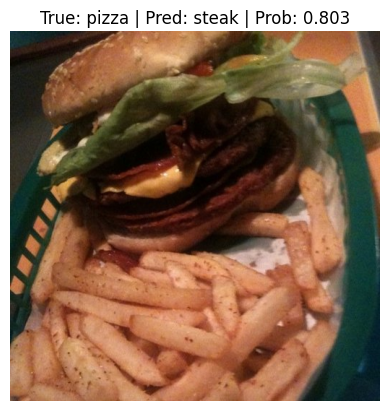

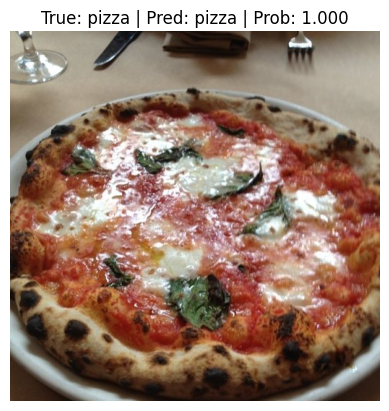

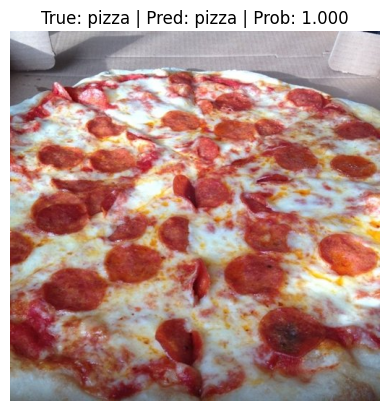

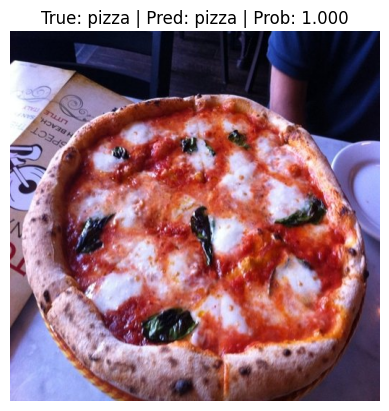

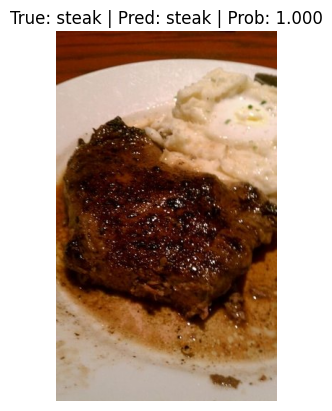

In [40]:
import torchvision
import matplotlib.pyplot as plt

for row in top_5_most_wrong.iterrows():
  row=row[1]
  image_path =row[0]
  true_label = row[1]
  pred_prob = row[2]
  pred_class = row[3]

  img = torchvision.io.read_image(str(image_path))
  plt.figure()
  plt.imshow(img.permute(1,2,0))
  plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob:.3f}")
  plt.axis(False);

# 5. Our custom ViT model architecture closely mimics that of the ViT paper, however, our training recipe misses a few things.
* Research some of the following topics from Table 3 in the ViT paper that we miss and write a sentence about each and how it might help with training:
    * **ImageNet-21k pretraining**
    * **Learning rate warmup**
    * **Learning rate decay**
    * **Gradient clipping**

In [ ]:
# TODO: your explanations of the above terms